# Visual Topic Modeling

In [33]:
import sys
sys.path.append('../../../')
import time
import torch

import numpy as np
import pandas as pd
import pickle

from sentence_transformers import SentenceTransformer, util
from src.helpers.postgres_helpers import execute_sql_select

## 1. Prepare embeddings

In [34]:
#Load sentences & embeddings from disc
with open('embeddings/img_embeddings.pkl', "rb") as f_in:
    data = pickle.load(f_in)
    img_paths = stored_data['images']
    embs = stored_data['embeddings']

len(embs), img_paths[0], embs.shape

(53895,
 '../../data/patriotischestimmedeutschlands/images/5289508368739848853.jpg',
 torch.Size([53895, 512]))

## Images only

In [35]:
from bertopic.representation import KeyBERTInspired, VisualRepresentation
from bertopic.backend import MultiModalBackend

# Image embedding model
embedding_model = MultiModalBackend('clip-ViT-B-32', batch_size=32)

# Image to text representation model
representation_model = {
    "Visual_Aspect": VisualRepresentation(image_to_text_model="nlpconnect/vit-gpt2-image-captioning")
}

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
from bertopic import BERTopic

# Train our model with images only
topic_model = BERTopic(embedding_model=embedding_model, representation_model=representation_model, min_topic_size=30)
topics, probs = topic_model.fit_transform(documents=None, images=images)

## Previous steps
- Collect data from BAG Telegram channels (1.-30.10.2023) via script `get_telegram_messages.py`
- Detect messages containing keywords related to IP war (see `EDA_v3_october.ipynb`)
- Encode all images from this dataset using CLIP model; see script `encode_images.py`
- The resulting embeddings are stored in `src/embeddings/israel_october/` in 30 batches as pickle files; keys = img_ids, values = embeddings
- The embeddings directory also contains an `overview.csv` which maps the img_id to the corresponding messages in the dataset

('../../data/patriotischestimmedeutschlands/images/5289508368739848853.jpg',
 torch.Size([53895, 512]))

## Load and prepare data

In [13]:
query = f"""
    SELECT img_id, file_path, dhash, phash
    FROM tg_oct_img_hashes
    """
data = execute_sql_select(command=query, database='telegram', return_result_as_df=True)

Column names:  ['img_id', 'file_path', 'dhash', 'phash']
Connection to DB closed


In [14]:
df = data.drop_duplicates(subset=['dhash'])
len(df)

53895

### 1.4 Combine img_ids as keys and retrieved embeddings as values
The keys in this dict represent the image ids and can later be used to reconstruct the corresponding image / message

In [31]:
embeddings = pd.DataFrame()
embeddings['img_paths'] = img_ids
embeddings['clip_embeddings'] = embs.cpu()
print(len(embeddings))
embeddings.head()

ValueError: Expected a 1D array, got an array with shape (53895, 512)

## 2. UMAP Dimensionality reduction

#### Params
First, the amount of datapoint classified as outliers is handled by the `min_samples` parameters in HDBSCAN. This value is automatically set to the same value of `min_cluster_size`. However, you can set it independently if you want to reduce the number of generated outliers. Lowering this value will result in less noise being generated.
 
##### UMAP (reduce dimensionality):

- `n_neigbors` (15): controls how UMAP balances local versus global structure in the data; kleine werte mehr Fokus auf lokale Strukturen
- `n_components` (5): Dimension; max auf 50 setzen, Performance drunter besser (aber quali umso höher desto besser I guess)
- `min_dist` (0.0): niedriger werte resultieren in clumpier results; As the `min_dist` parameter increases, UMAP tends to "spread out" the projected points, leading to decreased clustering of the data and less emphasis on global structure.


##### HDBSCAN (clustering):

- `min_cluster_size`: minimum size a final cluster can be; umso höher, desto größer cluster
- `min_samples` (= `min_cluster_size`): minimum number of neighbours to a core point.; Umso höher, desto mehr Punkte werden verworfen;

- *Increasing `min_samples` will increase the size of the clusters, but it does so by discarding data as outliers using DBSCAN.
- Increasing `min_cluster_size` while keeping `min_samples small`, by comparison, keeps those outliers but instead merges any smaller clusters with their most similar neighbour until all clusters are above `min_cluster_size`

-So: If you want many highly specific clusters, use a small `min_samples` and a small `min_cluster_size`.
- If you want more generalized clusters but still want to keep most detail, use a small `min_samples` and a large `min_cluster_size`.
- If you want very very general clusters and to discard a lot of noise in the clusters, use a large `min_samples` and a large `min_cluster_size`.

In [150]:
### 2.1 Create train, test split
#train, test = train_test_split(embeddings, train_size=0.8, random_state=42)
#train.reset_index(inplace=True)
#test.reset_index(inplace=True)
#len(train), len(test)

## UMAP - dimensionality reduction

In [151]:
## TODO define hyperparams
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
#https://medium.com/@FunCorp/image-clustering-using-clip-neural-network-f0a5a94563ac

In [152]:
DIMENSIONS = [5, 10, 15, 20, 25, 30, 50, 75, 100]
results = []

for dim in DIMENSIONS:  
    reducer = umap.UMAP(n_components=dim)#, n_neighbors=10)#, min_dist=0.1, metric='cosine')
    umap_embeddings = reducer.fit_transform(list(embeddings.clip_embeddings))
    results.append(umap_embeddings)

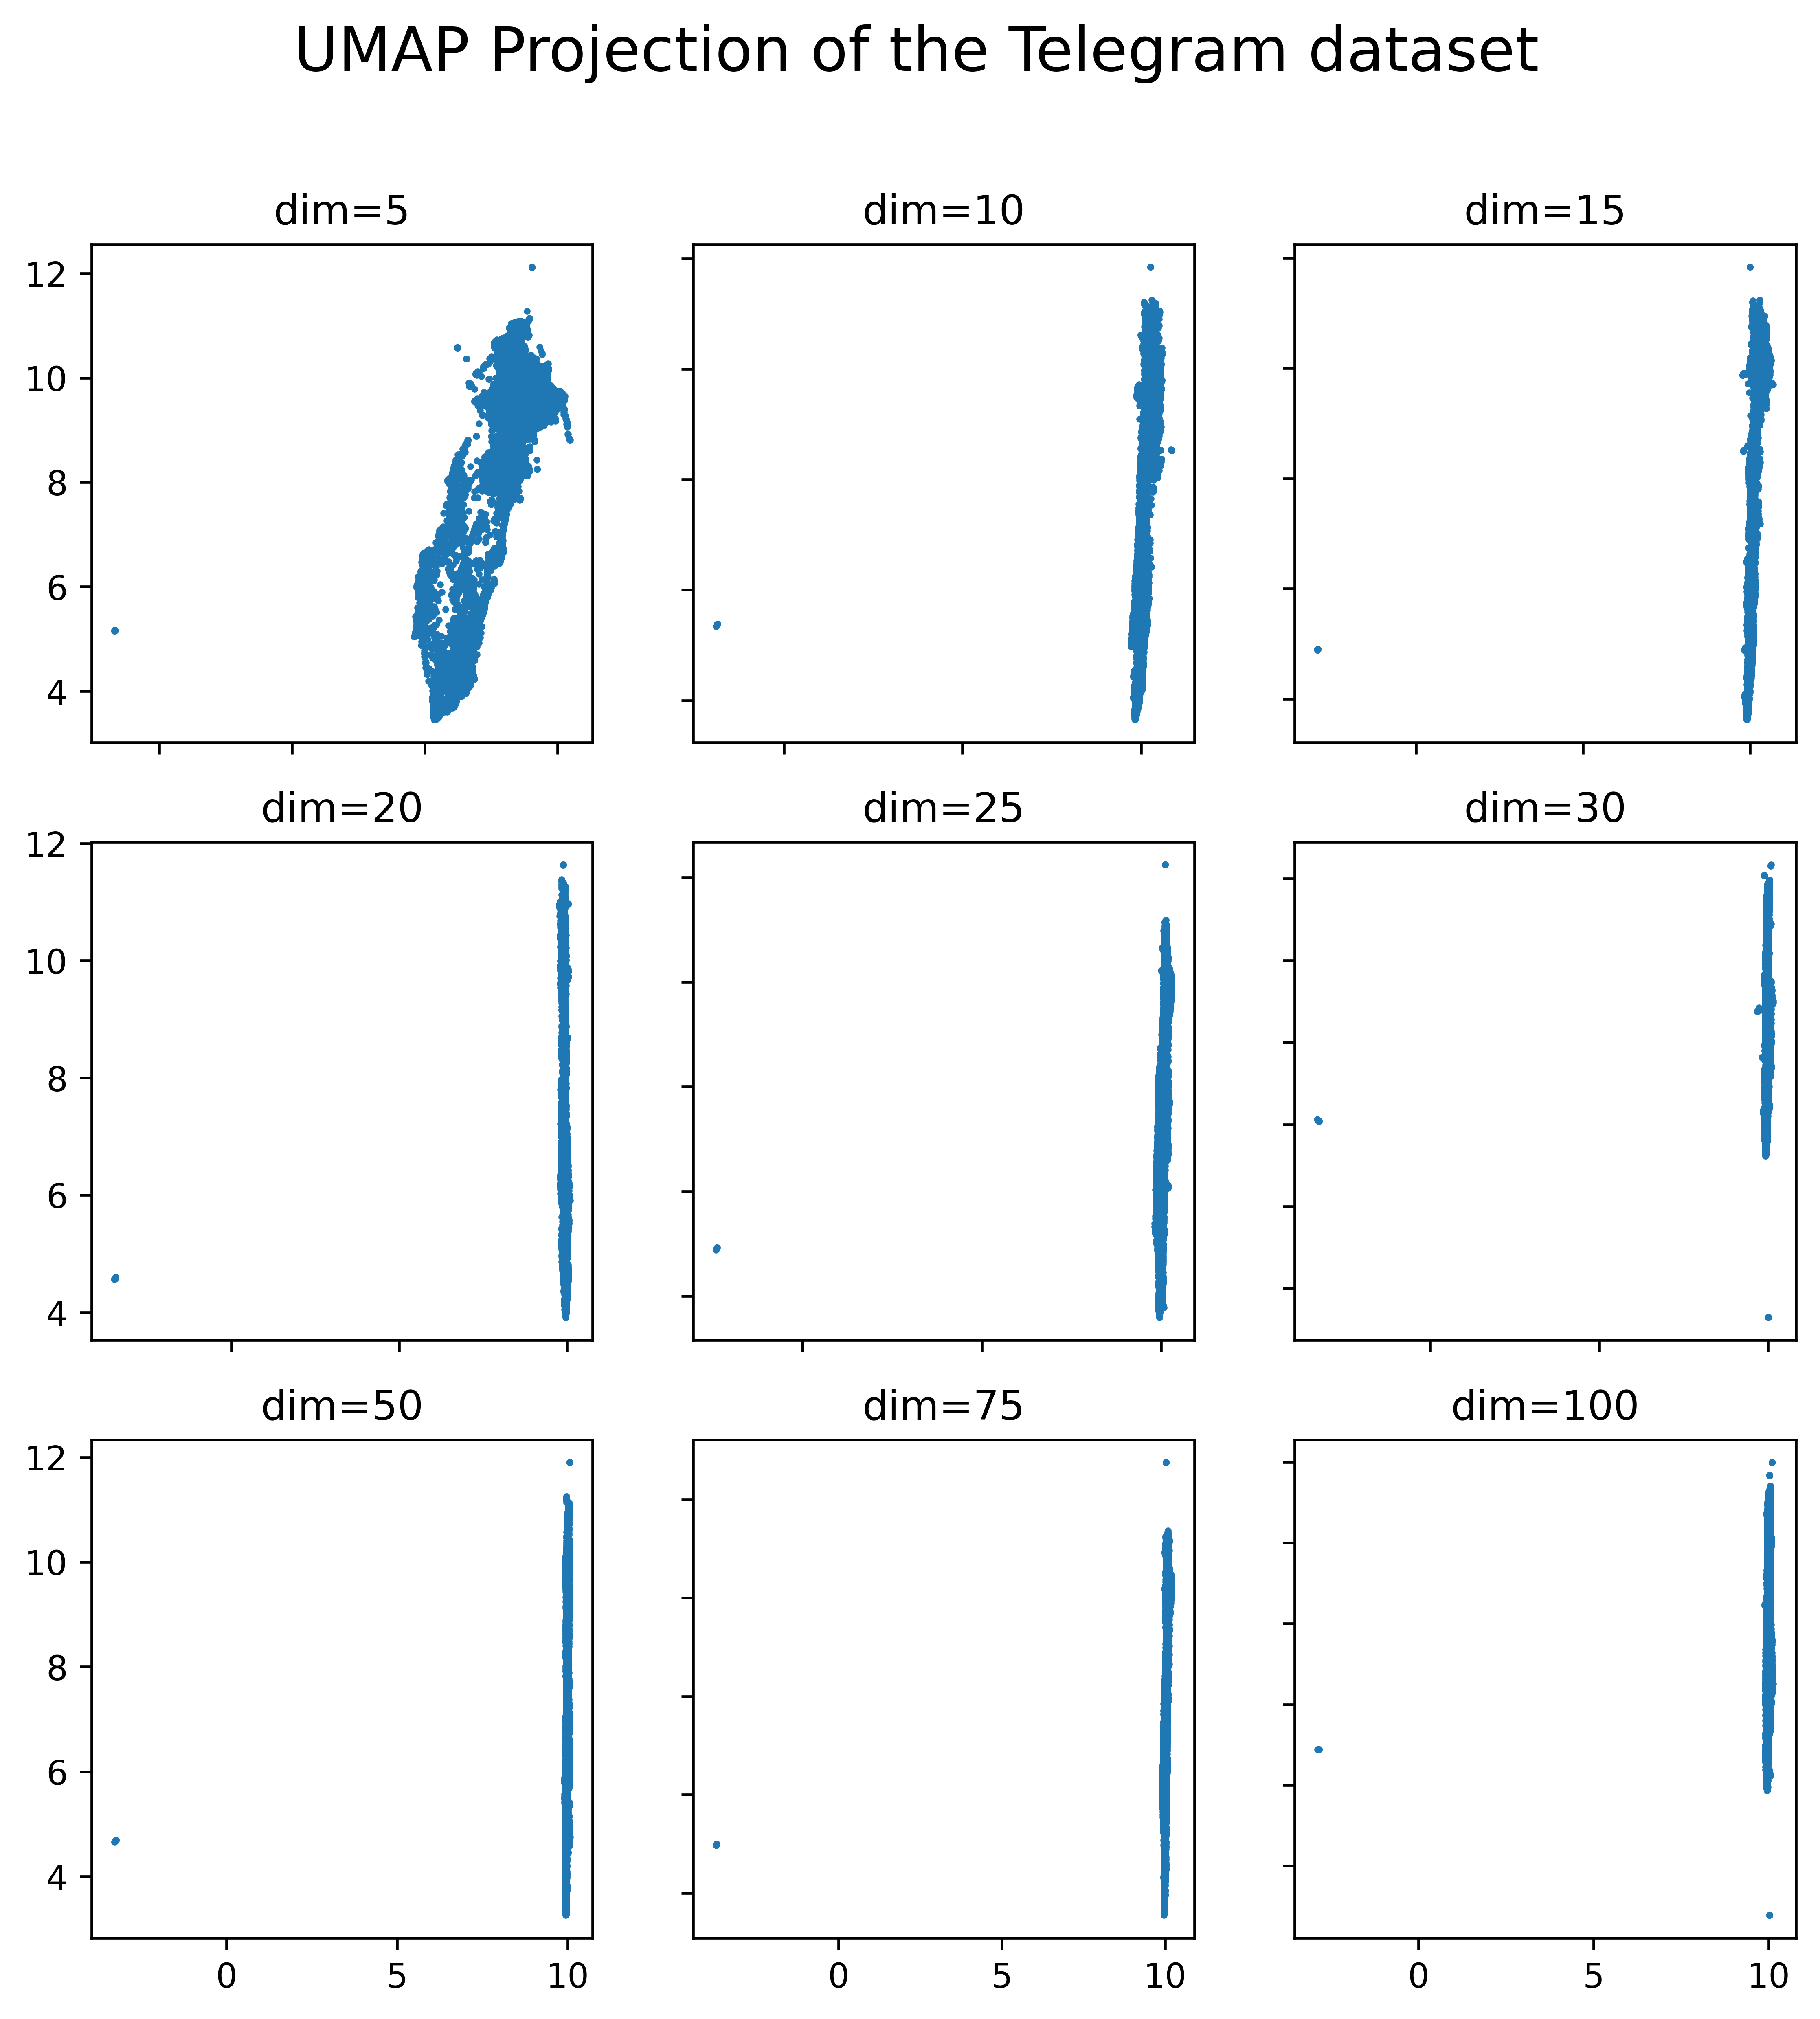

In [153]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(9, 9), dpi=600)
fig.suptitle('UMAP Projection of the Telegram dataset', size=18, weight=500)
size= 1

ax1.scatter(
    results[0][:, 0],
    results[0][:, 1],
    s=size)
ax1.set_title(f"dim={DIMENSIONS[0]}")

ax2.scatter(
    results[1][:, 0],
    results[1][:, 1],
    s=size)
ax2.set_title(f"dim={DIMENSIONS[1]}")

ax3.scatter(
    results[2][:, 0],
    results[2][:, 1],
    s=size)
ax3.set_title(f"dim={DIMENSIONS[2]}")

ax4.scatter(
    results[3][:, 0],
    results[3][:, 1],
    s=size)
ax4.set_title(f"dim={DIMENSIONS[3]}")

ax5.scatter(
    results[4][:, 0],
    results[4][:, 1],
    s=size)
ax5.set_title(f"dim={DIMENSIONS[4]}")

ax6.scatter(
    results[5][:, 0],
    results[5][:, 1],
    s=size)
ax6.set_title(f"dim={DIMENSIONS[5]}")

ax7.scatter(
    results[6][:, 0],
    results[6][:, 1],
    s=size)
ax7.set_title(f"dim={DIMENSIONS[6]}")

ax8.scatter(
    results[7][:, 0],
    results[7][:, 1],
    s=size)
ax8.set_title(f"dim={DIMENSIONS[7]}")

ax9.scatter(
    results[8][:, 0],
    results[8][:, 1],
    s=size)
ax9.set_title(f"dim={DIMENSIONS[8]}")

for ax in fig.get_axes():
    ax.label_outer()

## HDBSCAN - Clustering

In [154]:
from hdbscan import HDBSCAN, approximate_predict
#TODO install and use cuml for cuda acceleration of UMAP and HDBSCAN
#from cuml.cluster import HDBSCAN
#from cuml.manifold import UMAP
# https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

In [155]:
embeddings['umap_embedding'] = list(results[1])

In [156]:
clusterer = HDBSCAN(min_cluster_size=50, min_samples=25, gen_min_span_tree=True, prediction_data=True)
preds = clusterer.fit_predict(list(embeddings.umap_embedding))
labels, probabilities = approximate_predict(clusterer, list(embeddings.umap_embedding))
pd.DataFrame(labels).value_counts()

-1     3726
 4      872
 14     862
 24     738
 6      346
 1      285
 23     281
 11     270
 22     267
 21     248
 12     219
 20     219
 3      200
 9      168
 13     165
 17     162
 2      137
 18     131
 16     117
 15     115
 19      99
 8       99
 7       95
 0       69
 10      59
 5       51
Name: count, dtype: int64

In [157]:
embeddings['label'] = labels
embeddings['probs'] = probabilities
embeddings.head()

,img_ids,clip_embeddings,umap_embedding,label,probs
0,32488,"[0.08962608, 0.12454553, 0.13019675, 0.1201122...","[9.828474, 4.1384506, 4.138235, 9.491087, 5.21...",7,1.0
1,75963,"[-0.20323259, -0.3698725, 0.14939597, -0.18955...","[9.978257, 4.9862576, 2.1058176, 9.548533, 4.4...",-1,0.0
2,8952,"[0.2652609, 0.03445734, 0.16454366, 0.15447298...","[10.070523, 8.8376465, 2.9952888, 9.885922, 6....",-1,0.0
3,13136,"[0.027230188, 0.01180321, -0.07142219, -0.0979...","[10.027777, 4.964412, 1.7346734, 9.546172, 4.4...",4,1.0
4,12145,"[-0.3150373, 0.4816816, 0.08553832, 0.07297653...","[10.438608, 9.6252775, 3.1372187, 8.888486, 5....",-1,0.0


In [159]:
#embeddings.to_csv('3_results.csv')

<Axes: xlabel='label'>

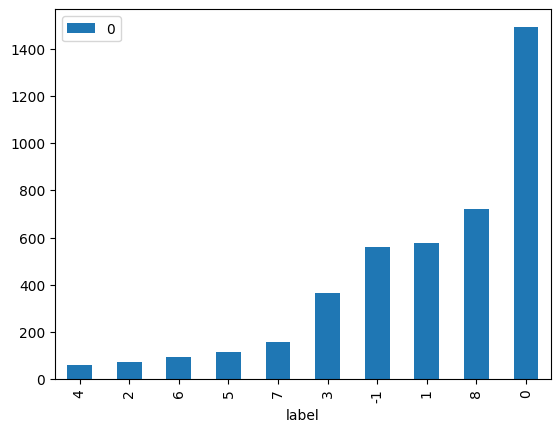

In [94]:
pd.DataFrame(embeddings.groupby('label').size().sort_values()).plot.bar()